# Continuous bag of words model

Let's take a look at the following sentence: 
>**'I am happy because I am learning'**. 

- In continuous bag of words (CBOW) modeling, we try to predict the center word given a few context words (the words around the center word).
- For example, if you were to choose a context half-size of say $C = 2$, then you would try to predict the word **happy** given the context that includes 2 words before and 2 words after the center word:

> $C$ words before: [I, am] 

> $C$ words after: [because, I] 

- In other words:

$$context = [I,am, because, I]$$
$$target = happy$$

The structure of your model will look like this:

<div style="width:image width px; font-size:100%; text-align:center;"><img src='https://raw.githubusercontent.com/amanchadha/coursera-natural-language-processing-specialization/master/2%20-%20Natural%20Language%20Processing%20with%20Probabilistic%20Models/Week%204/word2.png' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> Figure 1 </div>

Where $\bar x$ is the average of all the one hot vectors of the context words. 

<div style="width:image width px; font-size:100%; text-align:center;"><img src='https://raw.githubusercontent.com/amanchadha/coursera-natural-language-processing-specialization/master/2%20-%20Natural%20Language%20Processing%20with%20Probabilistic%20Models/Week%204/mean_vec2.png' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> Figure 2 </div>

Once you have encoded all the context words, you can use $\bar x$ as the input to your model. 

The architecture you will be implementing is as follows:

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
 \hat y &= softmax(z)   \tag{4} \\
\end{align}

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/13 - NLP/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/13 - NLP


In [ ]:
# Import Python libraries and helper functions (in utils2) 
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from lib.utils2 import *
import re                                                       
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load, tokenize and process the data
with open('./data/shakespeare.txt') as f:
    data = f.read()                                                
data = re.sub(r'[,!?;-]', '.',data)                                
data = nltk.word_tokenize(data)                                     
data = [ch.lower() for ch in data if ch.isalpha() or ch == '.']       
print(len(data))

60933


In [ ]:
# Compute the frequency distribution 
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ", len(fdist))
print(fdist.most_common(5))

Size of vocabulary:  5772
[('.', 9630), ('the', 1521), ('and', 1394), ('i', 1252), ('to', 1159)]


In [ ]:
def get_dict(data):
    words = sorted(list(set(data)))    
    word2Ind = {v:k for k,v in enumerate(words)}
    Ind2word = {k:v for k,v in enumerate(words)}
    return word2Ind, Ind2word

In [ ]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5772


# Model Training


In [ ]:
def initialize_model(N,V, random_seed=1):
    W1 = np.random.rand(N, V)
    W2 = np.random.rand(V, N)
    b1 = np.random.rand(N, 1)
    b2 = np.random.rand(V, 1)
    return W1, W2, b1, b2

def softmax(z):
    e_z = np.exp(z)
    yhat = e_z / np.sum(e_z, axis=0)    
    return yhat

def forward_prop(x, W1, W2, b1, b2):
    # Calculate h
    h = np.dot(W1, x) + b1 # (n_h, 1)
    # relu
    h = np.maximum(0, h)
    # Calculate z
    z = np.dot(W2, h) + b2 # (n_x, 1)
    return z, h

def compute_cost(y, yhat, batch_size):
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1 / batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

def get_vectors(data, word2Ind, V, C):
    i = C # 2
    while True:
        y = np.zeros(V) # 5778
        x = np.zeros(V) # 5778
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx_words = len(context_words) # 2 + 2
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq / num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            print('i is being set to 0')
            i = 0

def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch = []
            
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
     
    # Compute the gradient of W2
    grad_W2 = (1 / batch_size) * np.dot(yhat - y, h.T)
    
    # Compute the gradient of b2
    grad_b2 = np.sum((1 / batch_size) * np.dot(yhat - y, h.T), axis=1, keepdims=True)
    
    # Compute l1 as W2^T (Yhat - Y)
    l1 = np.dot(W2.T, (yhat - y))
    
    # Apply relu to l1
    l1[l1 < 0] = 0
    
    # Compute the gradient of W1
    grad_W1 = (1 / batch_size) * np.dot(l1, x.T) 
    
    # Compute the gradient of b1
    grad_b1 = np.sum((1 / batch_size) * np.dot(l1, x.T), axis=1, keepdims=True)
    
    return grad_W1, grad_W2, grad_b1, grad_b2

def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        z, h = forward_prop(x, W1, W2, b1, b2)
        yhat = softmax(z)
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2
                
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [ ]:
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V, tmp_C, tmp_batch_size))

print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N, tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_m = (2 * tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

tmp_x.shape (5772, 4)
tmp_y.shape (5772, 4)
tmp_W1.shape (50, 5772)
tmp_W2.shape (5772, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5772, 1)
tmp_z.shape: (5772, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5772, 4)
call compute_cost
tmp_cost 11.5721

call back_prop
tmp_grad_W1.shape (50, 5772)
tmp_grad_W2.shape (5772, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5772, 1)


In [ ]:
# gradient
C= 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.085093
iters: 20 cost: 0.034595
iters: 30 cost: 0.021802
iters: 40 cost: 0.015935
iters: 50 cost: 0.012563
iters: 60 cost: 0.010371
iters: 70 cost: 0.008832
iters: 80 cost: 0.007692
iters: 90 cost: 0.006813
iters: 100 cost: 0.006114
iters: 110 cost: 0.005709
iters: 120 cost: 0.005371
iters: 130 cost: 0.005070
iters: 140 cost: 0.004802
iters: 150 cost: 0.004560


# Visualization

In [ ]:
# visualizing the word vectors here
from matplotlib import pyplot
words = ['king', 'queen','lord','man', 'woman','dog','wolf', 'rich','happy','sad']
embs = (W1.T + W2) / 2.0
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)

(10, 50) [2743, 3947, 2959, 3021, 5669, 1452, 5668, 4186, 2315, 4273]


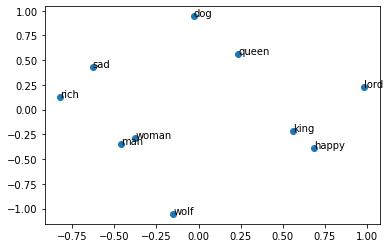

In [ ]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

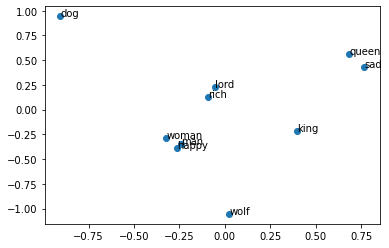

In [ ]:
result = compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()